In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
df = pd.read_excel("C:/Users/webde/Downloads/world-data.xlsx", header=None,
                  names=['Country', 'Population', 'Gdp', 'Happiness', 'Democracy', 'Inequality'])
print(f"Dataset Columns: {list(df.columns)}")
print(f"Dataset Shape: {df.shape}")
df.info()

Dataset Columns: ['Country', 'Population', 'Gdp', 'Happiness', 'Democracy', 'Inequality']
Dataset Shape: (112, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Country     112 non-null    object 
 1   Population  112 non-null    float64
 2   Gdp         112 non-null    float64
 3   Happiness   112 non-null    float64
 4   Democracy   112 non-null    float64
 5   Inequality  112 non-null    float64
dtypes: float64(5), object(1)
memory usage: 5.4+ KB


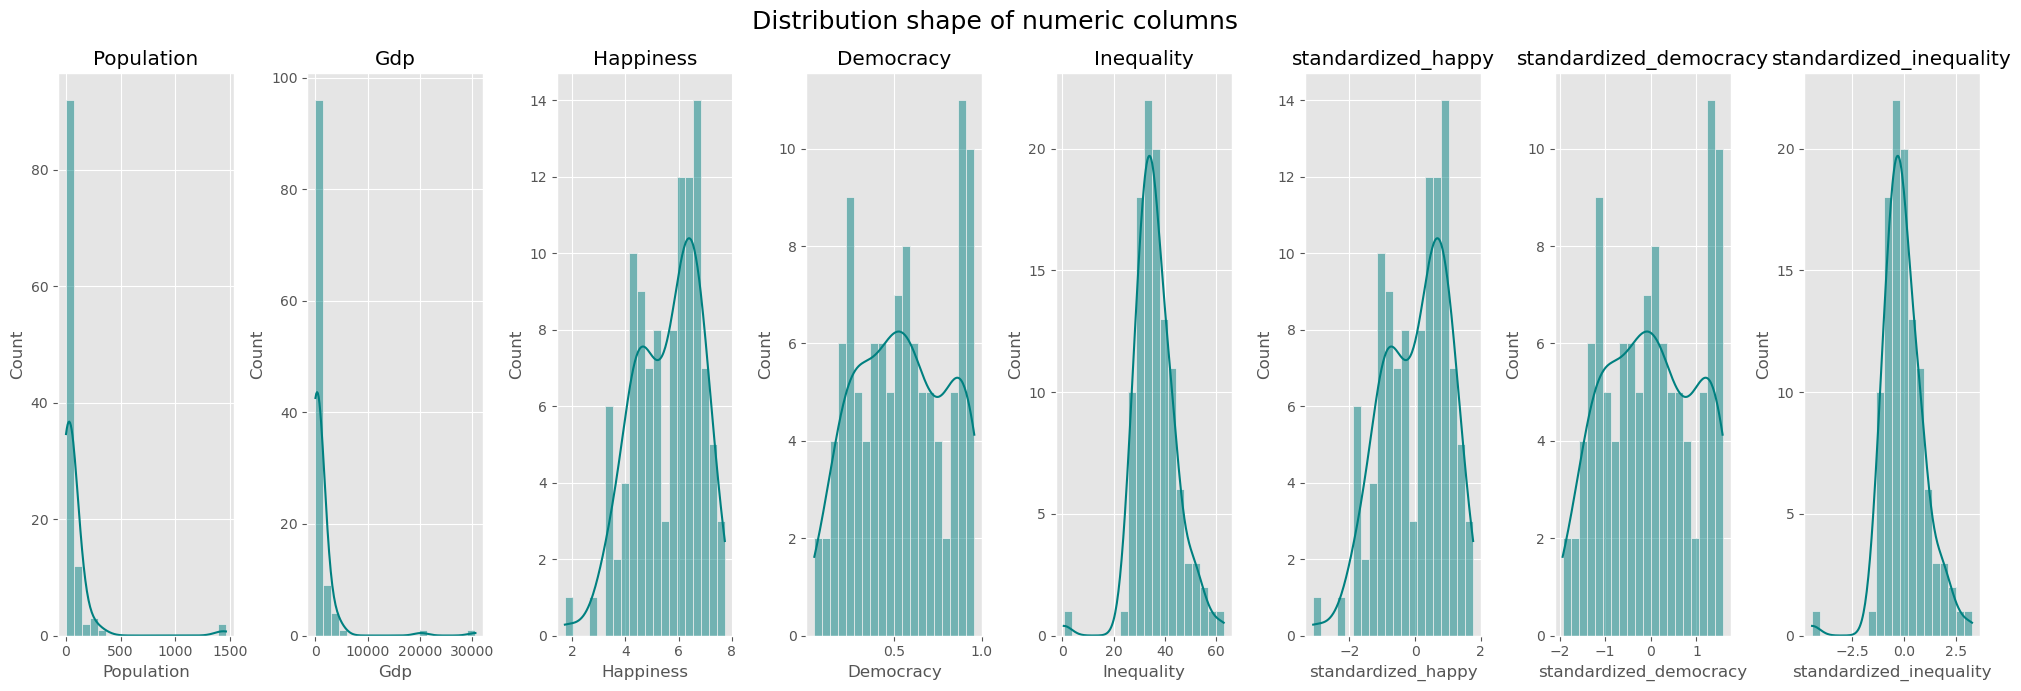

In [3]:
renamed_df = df.copy()
# renamed_df['standardized_gdp'] = ((renamed_df['Gdp'] - renamed_df['Gdp'].mean())/(renamed_df['Gdp'].std()))
renamed_df['standardized_happy'] = ((renamed_df['Happiness']-renamed_df['Happiness'].mean())/(renamed_df['Happiness'].std()))
renamed_df['standardized_democracy'] = ((renamed_df['Democracy']-renamed_df['Democracy'].mean())/(renamed_df['Democracy'].std()))
renamed_df['standardized_inequality'] = ((renamed_df['Inequality']-renamed_df['Inequality'].mean())/(renamed_df['Inequality'].std()))
numeric_cols = renamed_df.select_dtypes(include=[np.number])
col = renamed_df[['standardized_happy','standardized_democracy','standardized_inequality']]
fig, axes = plt.subplots(1, len(numeric_cols.columns), figsize=(20, 7))
for idx, col in enumerate(numeric_cols.columns):
	sns.histplot(data=numeric_cols, x=col, bins=20, color='teal', kde=True, ax=axes[idx])
	axes[idx].set_title(col)
plt.suptitle('Distribution shape of numeric columns', fontsize=18)
plt.tight_layout()
plt.show()

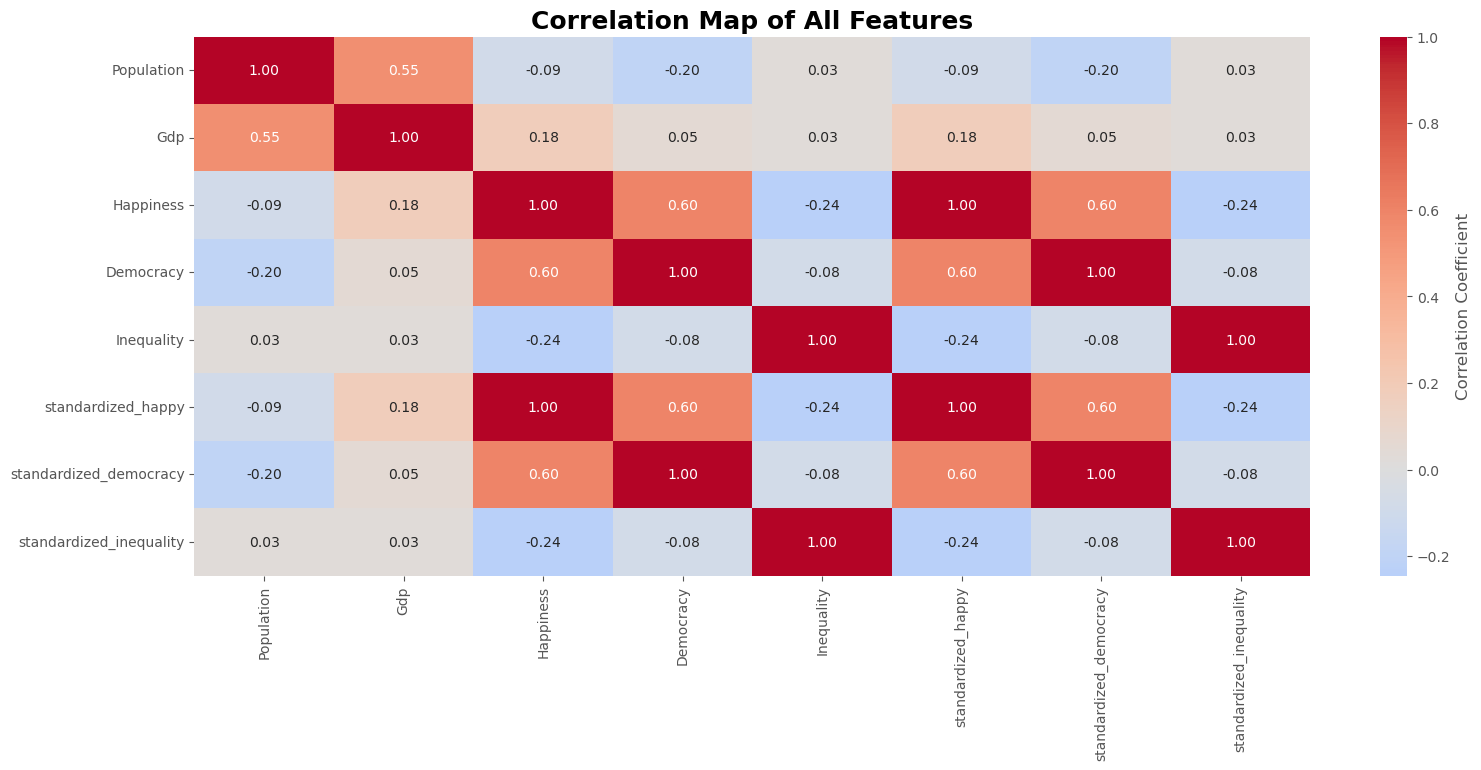

In [4]:
plt.figure(figsize=(18,7))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', center=0,fmt='0.2f',
            cbar_kws={'label':'Correlation Coefficient'})
plt.title('Correlation Map of All Features', fontsize=18, fontweight='bold')
plt.show()

In [5]:
import statsmodels.formula.api as smf
formula = 'Gdp~Population+standardized_happy+standardized_inequality'
reg = smf.ols(formula, data=renamed_df).fit()
print(f"Regression results:\n")
display(reg.summary())

Regression results:



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Gdp   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     19.75
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           2.81e-10
Time:                        14:21:55   Log-Likelihood:                -1048.4
No. Observations:                 112   AIC:                             2105.
Df Residuals:                     108   BIC:                             2116.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 316.3630    287.740      1.099      0.274    -253.987     886.713
Population                 10.1933      1.397      7.297      0.000       7.424      12.962
standardized_happy        845.4967    281.374      3.005      0.003     287.765    1403.228
standardized_inequality   236.2160    280.476      0.842      0.402    -319.737     792.169
==============================================================================
Omnibus:                      187.500   Durbin-Watson:                   0.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18660.428
Skew:                           6.546   Prob(JB):                         0.00
Kurtosis:                      64.865   Cond. No.                         239.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = renamed_df[['standardized_happy','Population','standardized_inequality']]
vif_data = pd.DataFrame({
	'Variables': X.columns,
 'VIF values': [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
})
print("VIF Results")
display(round(vif_data,3))

VIF Results


,Variables,VIF values
0,standardized_happy,1.070
1,Population,1.007
2,standardized_inequality,1.064


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y = renamed_df['Gdp']

model = LinearRegression()
model.fit(X,y)

y_pred = model.predict(X)

table_df = pd.DataFrame({
'Country': renamed_df['Country'].str.capitalize(),
'Actual': y,
"predicted": y_pred,
'Error(%)': 100*(y - y_pred/y)
})
all = table_df.sort_values('Actual')
display(round(all,2))

,Country,Actual,predicted,Error(%)
49,Gambia,2.70,-313.21,11870.36
105,Surinam,4.50,895.60,-19452.31
68,Eswatini,5.20,-547.16,11042.37
110,Maldives,7.26,-119.74,2375.26
47,Malawi,11.30,-859.11,8732.78
...,...,...,...,...
4,India,4130.00,14230.31,412655.44
3,Japan,4280.00,1841.82,427956.97
2,Germany,5010.00,1876.14,500962.55
1,China,20230.00,15015.36,2022925.78


In [8]:
# Prediction model validation

r2 = r2_score(y, y_pred)
print(f"R-Squared (regular model) : {r2:.3f}")
mean_actual_gdp = y.mean()
print(f"Actual GDP Mean: {mean_actual_gdp:.3f}")
mae = mean_absolute_error(y, y_pred)
print("Mean Absolute Error", round(mae,3))
mae_pct = 100*(mae/mean_actual_gdp)
print("Mean Absolute Error (%)", round(mae_pct,3))
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error", round(mse,3))
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE)", round(rmse,3))
rmse_pct = 100*(rmse/mean_actual_gdp)
print("RMSE (%)", round(rmse_pct,3))

R-Squared (regular model) : 0.354
Actual GDP Mean: 1027.808
Mean Absolute Error 1058.535
Mean Absolute Error (%) 102.99
Mean Squared Error 7915074.844
Root Mean Squared Error (RMSE) 2813.374
RMSE (%) 273.726


In [9]:
log_gdp = np.log(renamed_df['Gdp'])
formula = 'log_gdp~Population+standardized_happy+standardized_inequality'
log_reg = smf.ols(formula, data=renamed_df).fit()
print(f"="*30,"Regression Results")
display(log_reg.summary())

============================== Regression Results


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_gdp   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     37.42
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           1.16e-16
Time:                        14:21:59   Log-Likelihood:                -184.03
No. Observations:                 112   AIC:                             376.1
Df Residuals:                     108   BIC:                             386.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   4.9458      0.128     38.647      0.000       4.692       5.200
Population                  0.0043      0.001      6.927      0.000       0.003       0.006
standardized_happy          1.0454      0.125      8.353      0.000       0.797       1.293
standardized_inequality     0.0154      0.125      0.123      0.902      -0.232       0.263
==============================================================================
Omnibus:                        1.946   Durbin-Watson:                   1.315
Prob(Omnibus):                  0.378   Jarque-Bera (JB):                1.524
Skew:                          -0.276   Prob(JB):                        0.467
Kurtosis:                       3.151   Cond. No.                         239.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
log_y = log_gdp
log_model = LinearRegression()
log_model.fit(X,log_y)
log_y_pred = log_model.predict(X)

comparison = pd.DataFrame({
'Country': renamed_df['Country'].str.capitalize(),
'Actual': log_y,
'Predicted': log_y_pred,
'Error(%)': 100*(log_y - log_y_pred/log_y)
})
log_all = comparison.sort_values('Actual')
display(round(log_all,2))

,Country,Actual,Predicted,Error(%)
49,Gambia,0.99,4.06,-309.50
105,Surinam,1.50,5.56,-219.22
68,Eswatini,1.65,3.25,-31.99
110,Maldives,1.98,4.64,-35.95
47,Malawi,2.42,3.24,109.00
...,...,...,...,...
4,India,8.33,9.97,712.82
3,Japan,8.36,5.90,765.63
2,Germany,8.52,6.31,777.83
1,China,9.91,11.39,876.61


In [11]:
r2 = r2_score(log_y, log_y_pred)
print("R-Squared (log model)", round(r2,3))
log_actual_gdp = log_y.mean()
print("Actual Gdp (log model)",round(log_actual_gdp,2))
log_mae = mean_absolute_error(log_y, log_y_pred)
print("Mean Absolute Error (log model)", round(mae,3))
log_mae_pct = 100*(log_mae/log_actual_gdp)
print("Mean Absolute Error % (log model)", round(log_mae_pct,2))
log_mse = mean_squared_error(log_y, log_y_pred)
print("Mean Square Error (log Model)", round(log_mse,3))
log_rmse = np.sqrt(log_mse)
print("RMSE (log model)", round(log_rmse,3))
log_rmse_pct = 100*(log_rmse/log_actual_gdp)
print("RMSE % log model", round(log_rmse_pct,2))

R-Squared (log model) 0.51
Actual Gdp (log model) 5.25
Mean Absolute Error (log model) 1058.535
Mean Absolute Error % (log model) 19.04
Mean Square Error (log Model) 1.566
RMSE (log model) 1.251
RMSE % log model 23.85


In [12]:
print("="*25,"Comparative Validation (regular model vs Log model)")
table = pd.DataFrame({
	'Metric': ['R-Squared', 'MAE (%)', 'RMSE (%)'],
	'Regular Model': [r2_score(y, y_pred), mae_pct, rmse_pct],
	'Log Model': [r2_score(log_y, log_y_pred), log_mae_pct, log_rmse_pct]
})
display(round(table,2))


========================= Comparative Validation (regular model vs Log model)


,Metric,Regular Model,Log Model
0,R-Squared,0.35,0.51
1,MAE (%),102.99,19.04
2,RMSE (%),273.73,23.85
